In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого. 

In [2]:
class FaceDataset(Dataset):
    def __init__(self, data_df, transform=None):
        """
        Инициализируем класс передавая ему табличку 
        с данными об изображениях
        """
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['name'], self.data_df.iloc[idx]['label']
        
        # читаем картинку
        image = cv2.imread(f"data256/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [3]:
# задаем преобразование изображения

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [4]:
# читаем датасет

data_df = pd.read_csv("train.csv")

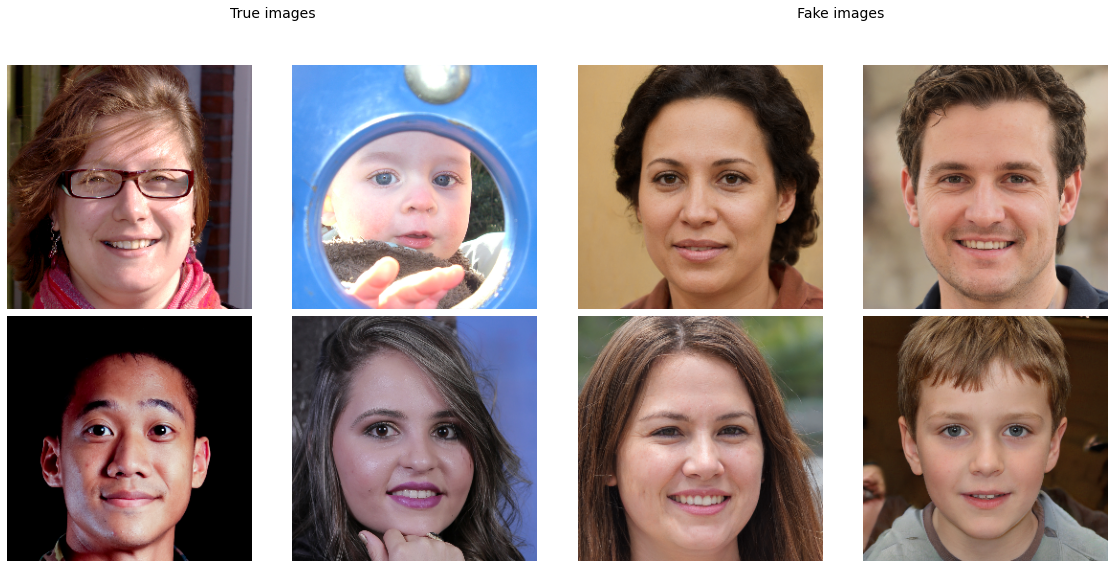

In [5]:
# посмотрим на картинки

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'True images {" "*105} Fake images', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['label'] == 0 ].sample(4, random_state=42)['name']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"data256/train/{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['label'] == 1 ].sample(4, random_state=42)['name']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"data256/train/{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

Довольно похожие, согласны?

In [6]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество

train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=42)

In [7]:
train_df.shape, valid_df.shape

((6400, 2), (1600, 2))

In [8]:
train_dataset = FaceDataset(train_df, train_transform)
valid_dataset = FaceDataset(valid_df, valid_transform)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=64,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

Отлично, теперь давайте напишем пару вспомогательных функций для визуализации и тренировки

## Вспомогательные функции

In [10]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [11]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()
        
        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

## Модель
Все, перейдем к обучению самой модели. Воспользуемся предобученным резнетом и заменим у него классификатор, а потом будем обучать только его.

In [12]:
# Подргружаем модель
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

In [13]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001)

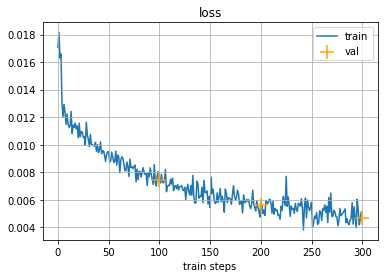

100%|██████████| 3/3 [00:56<00:00, 18.96s/it]

Train loss: 0.5199350542388856
Val loss: 0.46853391919285065
Train acc: tensor(90.5000, device='cuda:0')
Val acc: tensor(91.8125, device='cuda:0')


In [14]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 3)

## Посмотрим метрики нашей итоговой модели на валидации

In [15]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)
    
    valid_predicts.append(pred.softmax(dim=1)[:, 1].cpu().detach().numpy()) # argmax(dim=1)

100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


In [16]:
valid_predicts = np.concatenate(valid_predicts)

In [17]:
valid_df['pred'] = valid_predicts

/home/jovyan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Посчитаем аккураси

In [18]:
val_acc = (valid_df['label'].values == (valid_df['pred'].values >= 0.5)*1).mean()
print(f"Validation accuracy = {val_acc}")

Validation accuracy = 0.918125


А теперь, давайте еще и `roc-auc`

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [20]:
val_rocauc = roc_auc_score(valid_df['label'].values, valid_df['pred'].values)
print(f"Validation ROC-AUC = {val_rocauc}")

Validation ROC-AUC = 0.9776324264158731


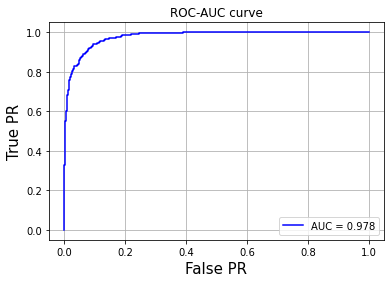

In [21]:
fpr, tpr, threshold = roc_curve(y_true=valid_df['label'].values, 
                                        y_score=valid_df['pred'].values, 
                                        pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('ROC-AUC curve')
plt.plot(fpr, tpr, c='b', label='AUC = '+str(np.round(roc_auc,3)))
plt.xlabel('False PR', fontsize=15)
plt.ylabel('True PR', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

Неплохо!

## Предскажем для теста

In [22]:
test_paths = glob.glob("data256/test/*.png")

In [23]:
test_names = [t_path.split('/')[-1] for t_path in test_paths]

In [24]:
test_df = pd.DataFrame(test_names, columns=['name'])

In [25]:
class TestFaceDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['name']
        
        # читаем картинку
        image = cv2.imread(f"data256/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [26]:
test_dataset = TestFaceDataset(test_df, valid_transform)

In [27]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

Предсказываем нашей моделью результат

In [28]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)
    
    predicts.append(pred.softmax(dim=1)[:, 1].cpu().detach().numpy()) # argmax(dim=1)

100%|██████████| 188/188 [01:04<00:00,  2.91it/s]


In [29]:
predicts = np.concatenate(predicts)

In [30]:
submit_df = pd.DataFrame([[name, pred] for name, pred in zip(test_names, predicts)], columns=['name', 'pred'])

In [31]:
submit_df = submit_df.sort_values(['name'])
submit_df.sample(5)

,name,pred
11437,test_3188957142034062.png,0.626585
8925,test_3793392780168042.png,0.801947
717,test_1958775688894682.png,0.312816
8126,test_3731626987235882.png,0.425400
461,test_849134677751003.png,0.347007


Получаем финальный файлик `submit.csv`, отсортированный по имени

In [33]:
submit_df.to_csv("submit.csv", index=False)